# Sentiment Analysis

Wir schauen uns drei Methoden an:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words Ansatz
2. Roberta Pretrained Model von 🤗
3. Extra: Hugging Face Pipeline

# Step 0. Daten importieren

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielpolak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danielpolak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/danielpolak/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/danielpolak/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danielpolak/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [41]:
df = pd.read_csv('amz.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(108, 8)
(108, 8)


In [42]:
df['score'] = pd.to_numeric(df['score'], errors='coerce')

In [43]:
df.head()

,id,author,score,title,content,date,verified,image_url
0,70a1f0bb-d834-5509-bfcc-b06f3286bdd9,EightySeven,1.0,How has nobody mentioned the audio with this c...,\nMy phone vibrates so bad in my hand by using...,"Reviewed in the United States on July 5, 2021",Verified Purchase,NaN
1,d4152a05-94b9-53e6-837e-62b99fe6f9da,NerdTech,1.0,good looking and very protective,\nI would buy again but dont need to. works p...,"Reviewed in the United States on March 29, 2021",Verified Purchase,https://m.media-amazon.com/images/I/71DL9PG2d-...
2,2f19c789-34ca-5a70-8063-2a695bc59c8c,William J. Marcellus,1.0,Cracked screen after first drop,\nMy one month old Pixel 5 screen completely s...,"Reviewed in the United States on January 4, 2022",Verified Purchase,NaN
3,1f6dc79d-9d29-5477-8472-6977990a001d,Rafael,1.0,Waste of money. Buy something else.,\nIt definitely didn't protect my phone from a...,"Reviewed in the United States on July 31, 2022",Verified Purchase,https://m.media-amazon.com/images/I/51O2Lb7mYl...
4,a0e6f306-3a9f-5c0d-8f1a-6a61d011eb55,James P,1.0,Disappointing,\nIt didn't protect my phone from a 3 foot dro...,"Reviewed in the United States on June 21, 2022",Verified Purchase,NaN


## Daten

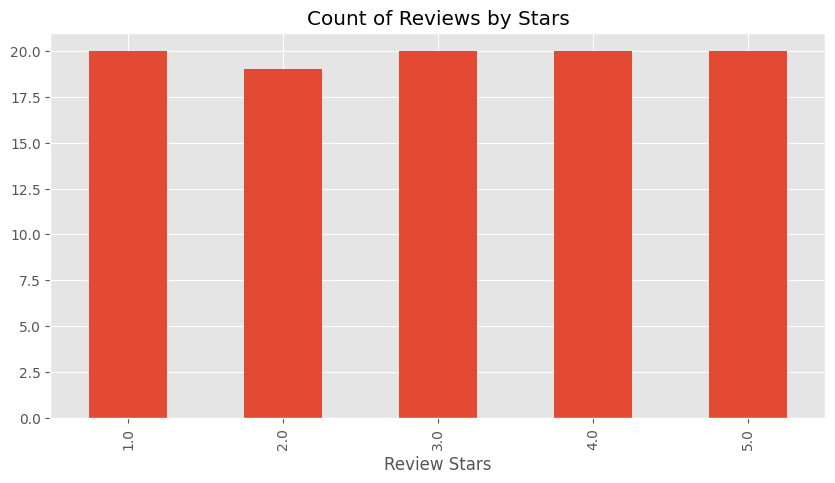

In [44]:
ax = df['score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

Datensatz ist sehr gut verteilt, da wir beim Scraping von allen nahezu gleich viele Bewertungen genommen haben

## Basic NLTK (Natural Language Toolkit)

In [45]:
example = df['content'][5]
print(example)


This is not worth more than $1.50. Cheap, thin rubber with no grip to the material. Super light weight due to the useless material.



In [46]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'is', 'not', 'worth', 'more', 'than', '$', '1.50', '.', 'Cheap']

In [47]:
# POS = Part-of-Speech Tagging
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('worth', 'IN'),
 ('more', 'JJR'),
 ('than', 'IN'),
 ('$', '$'),
 ('1.50', 'CD'),
 ('.', '.'),
 ('Cheap', 'NNP')]

DT = Determinierer (Artikel oder Begleiter)
VBZ = Verb
RB = Adverb
IN = Preposition/Subordinating conjunction (Präposition, untergeordnete Konjunktion)
JJR = Adjective, comparative (komparatives Adjektiv)
CD = Cardinal number (Kardinalzahl)
NNP = Proper noun, singular (Eigenname im Singular)
NN = Noun, singular or mass(Nomen, Singular oder Massenbegriff)

--> Fehler bei "Cheap"


In [48]:
tokens[9] = "cheap"
print(tokens[9])

cheap


In [49]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('worth', 'IN'),
 ('more', 'JJR'),
 ('than', 'IN'),
 ('$', '$'),
 ('1.50', 'CD'),
 ('.', '.'),
 ('cheap', 'NN')]

In [50]:
# Named Entity Recognition (NER)
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  is/VBZ
  not/RB
  worth/IN
  more/JJR
  than/IN
  $/$
  1.50/CD
  ./.
  cheap/NN
  ,/,
  thin/JJ
  rubber/NN
  with/IN
  no/DT
  grip/NN
  to/TO
  the/DT
  material/NN
  ./.
  (PERSON Super/NNP)
  light/JJ
  weight/NN
  due/JJ
  to/TO
  the/DT
  useless/JJ
  material/NN
  ./.)


# Step 1. VADER Seniment Scoring

Wir benutzen NLTK's `SentimentIntensityAnalyzer`, um die neg/neu/pos Scores von dem Text zu bestimmen.

- Hier wird der "bag of words" Ansatz benutzt:
    1. Stop words wurden entfernt.
    2. Jedes Wort hat einen Score und wird in einem gesamten Score kombiniert.

In [51]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer() #Vader

#### Compound
- Ein Compound-Wert nahe 1 deutet auf stark positives Sentiment hin.
- Ein Compound-Wert nahe -1 deutet auf stark negatives Sentiment hin.
- Ein Compound-Wert nahe 0 deutet auf neutrales Sentiment hin.

#### Pos,Neg,Neu
- neg: Prozentsatz des Textes, der als negativ eingestuft wird.
- neu: Prozentsatz des Textes, der als neutral eingestuft wird.
- pos: Prozentsatz des Textes, der als positiv eingestuft wird.


In [52]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [53]:
sia.polarity_scores('Good case, fits perfect.')

{'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.765}

In [54]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [55]:
print(example)
sia.polarity_scores(example)


This is not worth more than $1.50. Cheap, thin rubber with no grip to the material. Super light weight due to the useless material.



{'neg': 0.218, 'neu': 0.654, 'pos': 0.128, 'compound': -0.194}

In [56]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/108 [00:00<?, ?it/s]

In [57]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [58]:
vaders.head()

,id,neg,neu,pos,compound,author,score,title,content,date,verified,image_url
0,70a1f0bb-d834-5509-bfcc-b06f3286bdd9,0.130,0.801,0.068,-0.6371,EightySeven,1.0,How has nobody mentioned the audio with this c...,\nMy phone vibrates so bad in my hand by using...,"Reviewed in the United States on July 5, 2021",Verified Purchase,NaN
1,d4152a05-94b9-53e6-837e-62b99fe6f9da,0.116,0.716,0.168,0.6289,NerdTech,1.0,good looking and very protective,\nI would buy again but dont need to. works p...,"Reviewed in the United States on March 29, 2021",Verified Purchase,https://m.media-amazon.com/images/I/71DL9PG2d-...
2,2f19c789-34ca-5a70-8063-2a695bc59c8c,0.205,0.684,0.111,-0.5709,William J. Marcellus,1.0,Cracked screen after first drop,\nMy one month old Pixel 5 screen completely s...,"Reviewed in the United States on January 4, 2022",Verified Purchase,NaN
3,1f6dc79d-9d29-5477-8472-6977990a001d,0.191,0.733,0.076,-0.4726,Rafael,1.0,Waste of money. Buy something else.,\nIt definitely didn't protect my phone from a...,"Reviewed in the United States on July 31, 2022",Verified Purchase,https://m.media-amazon.com/images/I/51O2Lb7mYl...
4,a0e6f306-3a9f-5c0d-8f1a-6a61d011eb55,0.212,0.644,0.144,-0.0987,James P,1.0,Disappointing,\nIt didn't protect my phone from a 3 foot dro...,"Reviewed in the United States on June 21, 2022",Verified Purchase,NaN


## Plot VADER results

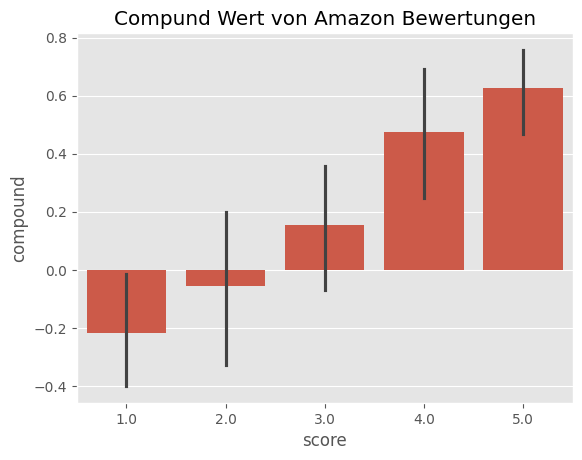

In [59]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Compund Wert von Amazon Bewertungen')
plt.show()

Wie man sieht passt der Compund Wert zu den Scores.

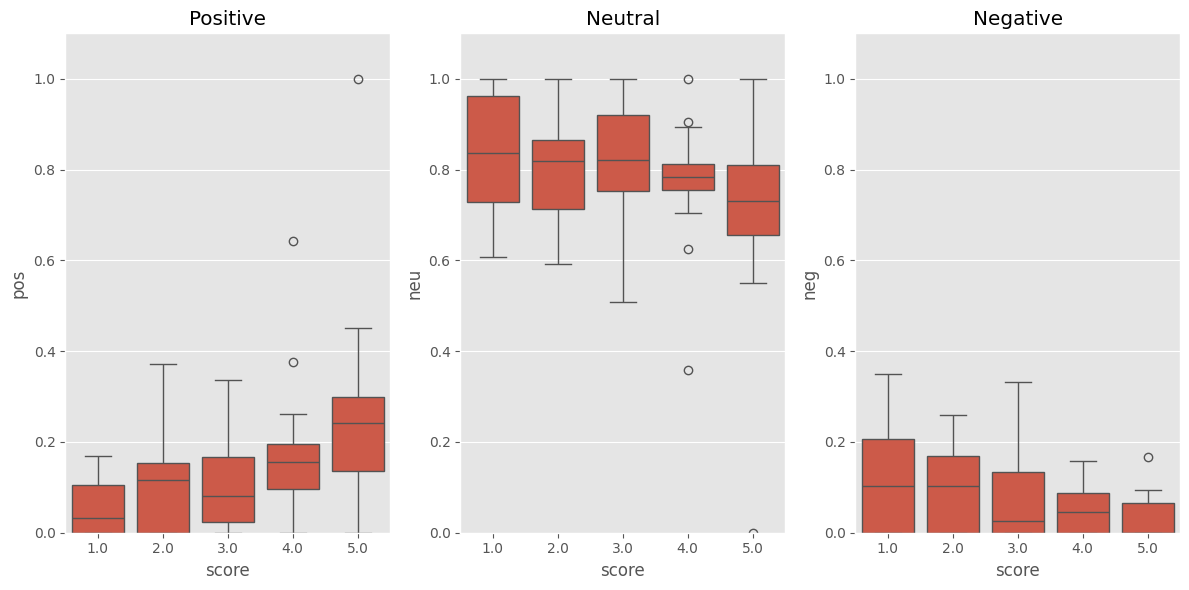

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.boxplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.boxplot(data=vaders, x='score', y='neg', ax=axs[2])

# Setzen der y-Achsenlimits für alle Achsen auf [0, 1]
for ax in axs:
    ax.set_ylim(0, 1.1)

# Titel setzen
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

# Layout anpassen
plt.tight_layout()

# Anzeigen des Plots
plt.show()

Positive Worte werden tendenziell bei höheren Bewertungen verwendet, während negative Worte bei niedrigeren Bewertungen verwendet werden.
Neutrale gibt es überall.

# Step 3. Pretrained Model Roberta 

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [61]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [62]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/Users/danielpolak/miniconda3/envs/webmining/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [63]:
# VADER results on example
print(example)
sia.polarity_scores(example)


This is not worth more than $1.50. Cheap, thin rubber with no grip to the material. Super light weight due to the useless material.



{'neg': 0.218, 'neu': 0.654, 'pos': 0.128, 'compound': -0.194}

In [64]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9336949, 'roberta_neu': 0.059390217, 'roberta_pos': 0.0069149947}


In [65]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [66]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['content']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/108 [00:00<?, ?it/s]

In [67]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

# Step 3. Combine and compare

In [68]:
#Es geht nur darum welche Art(pos,neu,neg) von Wörtern werden für eine Bewertung/Score genutzt. 

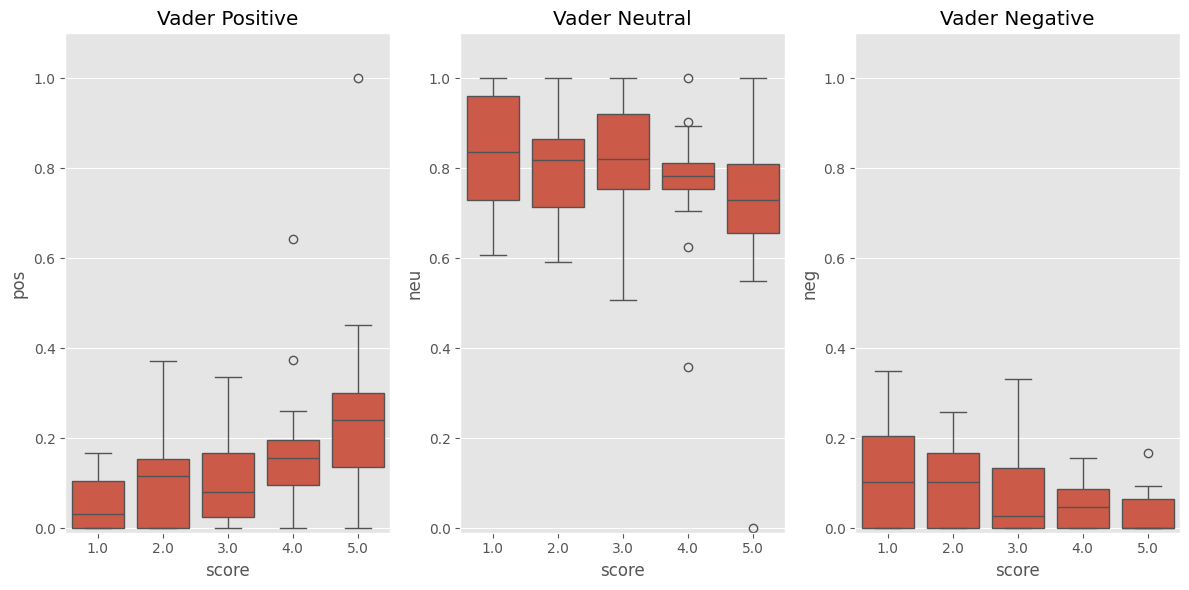

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.boxplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.boxplot(data=vaders, x='score', y='neg', ax=axs[2])

# Setzen der y-Achsenlimits für alle Achsen auf [0, 1]
for ax in axs:
    ax.set_ylim(-0.01, 1.1)

# Titel setzen
axs[0].set_title('Vader Positive')
axs[1].set_title('Vader Neutral')
axs[2].set_title('Vader Negative')

# Layout anpassen
plt.tight_layout()

# Anzeigen des Plots
plt.show()

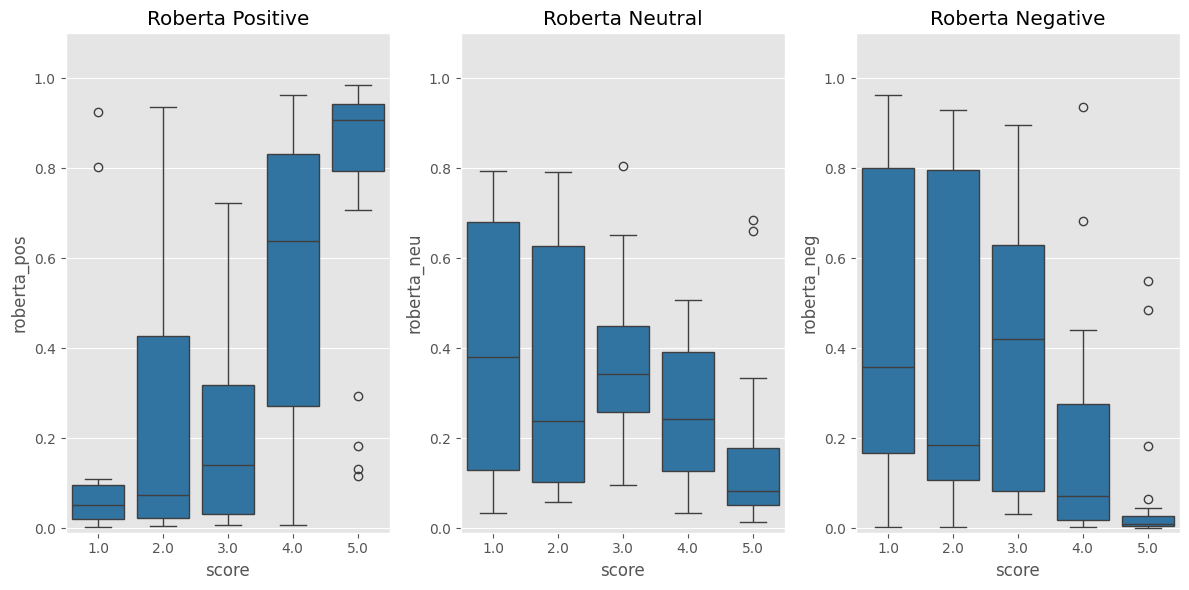

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=results_df, x='score', y='roberta_pos', ax=axs[0], color='#1f77b4')
sns.boxplot(data=results_df, x='score', y='roberta_neu', ax=axs[1], color='#1f77b4')
sns.boxplot(data=results_df, x='score', y='roberta_neg', ax=axs[2], color='#1f77b4')

# Setzen der y-Achsenlimits für alle Achsen auf [0, 1]
for ax in axs:
    ax.set_ylim(-0.01, 1.1)

# Titel setzen
axs[0].set_title('Roberta Positive')
axs[1].set_title('Roberta Neutral')
axs[2].set_title('Roberta Negative')

# Layout anpassen
plt.tight_layout()

# Anzeigen des Plots
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [29]:
results_df.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,author,score,title,content,date,verified,image_url
0,70a1f0bb-d834-5509-bfcc-b06f3286bdd9,0.130,0.801,0.068,-0.6371,0.961939,0.034244,0.003816,EightySeven,1.0,How has nobody mentioned the audio with this c...,\nMy phone vibrates so bad in my hand by using...,"Reviewed in the United States on July 5, 2021",Verified Purchase,NaN
1,d4152a05-94b9-53e6-837e-62b99fe6f9da,0.116,0.716,0.168,0.6289,0.048756,0.148157,0.803086,NerdTech,1.0,good looking and very protective,\nI would buy again but dont need to. works p...,"Reviewed in the United States on March 29, 2021",Verified Purchase,https://m.media-amazon.com/images/I/71DL9PG2d-...
2,2f19c789-34ca-5a70-8063-2a695bc59c8c,0.205,0.684,0.111,-0.5709,0.924532,0.067372,0.008096,William J. Marcellus,1.0,Cracked screen after first drop,\nMy one month old Pixel 5 screen completely s...,"Reviewed in the United States on January 4, 2022",Verified Purchase,NaN
3,1f6dc79d-9d29-5477-8472-6977990a001d,0.191,0.733,0.076,-0.4726,0.931671,0.062395,0.005935,Rafael,1.0,Waste of money. Buy something else.,\nIt definitely didn't protect my phone from a...,"Reviewed in the United States on July 31, 2022",Verified Purchase,https://m.media-amazon.com/images/I/51O2Lb7mYl...
4,a0e6f306-3a9f-5c0d-8f1a-6a61d011eb55,0.212,0.644,0.144,-0.0987,0.573507,0.375040,0.051453,James P,1.0,Disappointing,\nIt didn't protect my phone from a 3 foot dro...,"Reviewed in the United States on June 21, 2022",Verified Purchase,NaN


In [30]:
results_df.query('score == 1') \
    .sort_values('roberta_pos', ascending=False)['content'].values[0]

'\nThe case is okay but there is issue while using it i triggered accidental touches of case due to edge to edge display and gesture control becomes tough in few times\n'

In [31]:
results_df.query('score == 1') \
    .sort_values('vader_pos', ascending=False)['content'].values[0]

"\nI would buy again but dont need to.  works perfectly and looks nice!Update.Have the green back of phone and case left imprint of it's fancy design on the back of the phone that won't come off.  Good luck to me to sell this phone now.  Damages your phone.\n"

In [32]:
results_df.query('score == 5') \
    .sort_values('roberta_neg', ascending=False)['content'].values[0]

"\nI drop my phone constantly.Not just small drops either, sometimes I'll just accidentally chuck the thing across a parking lot because I guess I'm clumsy.I don't know if it's just the Pixel 5 being a tough phone or this case working some crazy magic to protect it from my constant blunders but for this price I don't really care.Grippy and looks neat but isn't too much visually.\n"

In [33]:
results_df.query('score == 5') \
    .sort_values('vader_neg', ascending=False)['content'].values[0]

'\nSimple, slim, adds a little protection without the bulk, good price, just what I wanted\n'

# Extra: The Transformers Pipeline
- Einfach und Schnell für sentiment predictions

In [34]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Users/danielpolak/miniconda3/envs/webmining/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
sent_pipeline('I am not sure if I like it')

[{'label': 'NEGATIVE', 'score': 0.9977300763130188}]

In [36]:
sent_pipeline('It tastes okay')

[{'label': 'POSITIVE', 'score': 0.9997593760490417}]

# The End